## Exploratory Data Analysis of a subset of data from 123i

The dataset contains price estimates for units in residential buildings in different locations in Brazil. The size of the data, especially regarding the number of variables, is a limiting factor but, nevertheless, interesting information can be extracted from it by approaching the data with a reverse-engineering mindset.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [5]:
data = pd.read_csv("../data/base_123i.csv")

In [6]:
data.dtypes

city                object
state               object
address             object
tower_name          object
building_type       object
rooms                int64
garages              int64
useful_area          int64
latitude            object
longitude           object
point_estimate       int64
minimum_estimate     int64
maximum_estimate     int64
dtype: object

In [7]:
data.head()

,city,state,address,tower_name,building_type,rooms,garages,useful_area,latitude,longitude,point_estimate,minimum_estimate,maximum_estimate
0,São Paulo,sp,"Alameda Itu, 254",Torre única,Apartamento,3,1,177,-23.56619840,-46.65689950,2111490,1794760,2428210
1,São Paulo,sp,"Alameda Santos, 1398",Torre única,Apartamento,2,1,65,-23.56387020,-46.65560060,608870,517539,700200
2,São Paulo,sp,"Avenida Paulista, 1195",Torre única,Apartamento,3,1,170,-23.56406910,-46.65356350,2102470,1787100,2417840
3,São Paulo,sp,"Avenida Paulista, 1195",Torre única,Apartamento,4,3,223,-23.56406910,-46.65356350,2757950,2344260,3171640
4,São Paulo,sp,"Alameda Santos, 1126",Torre única,Apartamento,3,1,100,-23.56533980,-46.65376750,1125720,956862,1294580


In [8]:
data.shape

(103953, 13)

The general formulaic approach would suggest starting by getting some summarized statistics, but we should already start by asking questions and applying some critical thinking. 

The first questions and observations that arise just by looking at the variables are the following:
 - 1. The first entries (head above) are for São Paulo city, specifically a small region bordering Paulista Avenue. What other places do we have data from?
 - 2. The dataset is quite small. Does it have enough data for every region available?
 - 3. The precision of the latitude and longitude seems exaggerated (~1mm)
 - 4. There are maximum and minimum estimates that are worth investigating (error range)

### 1. What other locations do we have data from?

In [9]:
data.city.value_counts()

São Paulo                  29006
Rio de Janeiro             16445
Belo Horizonte              8794
Porto Alegre                6921
Curitiba                    4813
Salvador                    3758
Santos                      3093
Recife                      2693
Fortaleza                   2477
Brasilia                    1979
Vitoria                     1966
Campinas                    1837
Florianopolis               1599
Goiania                     1532
Guaruja                     1521
Joao Pessoa                 1497
Niteroi                     1437
São Bernardo do Campo       1350
Santo André                 1255
Maceio                      1018
Belém                       1016
Vila Velha                   911
Natal                        887
São Caetano do Sul           883
Ribeirao Preto               684
Osasco                       596
Guarulhos                    549
Manaus                       481
Sao Luis                     444
Cuiaba                       324
Riviera de

Some issues are already visible. There are entries with correct grammar (accented) and other entries without accent, although they refer to the same location (e.g. São Luis / Sao Luis). Also, there seems to be an encoding problem for 8 entries for `São Paulo`.

I ran over the raw data quickly and noticed a lot of entries that have inconsistent data. It's worth taking a look at it now.

In [10]:
data.point_estimate.value_counts()[:5]

-1         82991
 371633       15
 466729       13
 550026       13
 629359       12
Name: point_estimate, dtype: int64

The null value seems to be `-1` for every variable. Since this field represents the label we unfortunately can't afford using those entries.

In [11]:
data = data[data.point_estimate != -1]

In [12]:
data.shape

(20962, 13)

The data shrank 80% from the original data that was already very small. We should investigate if we still have a good amount of data available even for a few locations.

In [13]:
data.city.value_counts()

São Paulo                  20588
Santos                       159
Riviera de Sao Lourenco       85
São Bernardo do Campo         38
Sao Bernardo do Campo         37
Florianopolis                 30
Campinas                      22
Rio de Janeiro                 2
Cuiaba                         1
Name: city, dtype: int64

It's evident that we don't have enough data to work with locations other than São Paulo, at least not sufficient for machine learning usage. For a machine learning model there is no hard rule, but generally for convergence of a few models (by convergence I'm also considering the generalization aspect) it would be nice to have a larger sample size. Although the sample sizes for `Santos` and `Riviera de São Lourenço` aren't that small (compared to the number of variables/features), we will disregard them with a recommendation for using the data with caution and maybe prefer heuristics in this case.

Other important thing to notice is that if we had decided to keep those locations, the relationship between features and among features would be heavily influenced by `São Paulo`'s, which may not hold true for other locations.

That responds our question number `2`.

In [14]:
data = data[data.city == 'São Paulo']

In [15]:
data.head()

,city,state,address,tower_name,building_type,rooms,garages,useful_area,latitude,longitude,point_estimate,minimum_estimate,maximum_estimate
0,São Paulo,sp,"Alameda Itu, 254",Torre única,Apartamento,3,1,177,-23.56619840,-46.65689950,2111490,1794760,2428210
1,São Paulo,sp,"Alameda Santos, 1398",Torre única,Apartamento,2,1,65,-23.56387020,-46.65560060,608870,517539,700200
2,São Paulo,sp,"Avenida Paulista, 1195",Torre única,Apartamento,3,1,170,-23.56406910,-46.65356350,2102470,1787100,2417840
3,São Paulo,sp,"Avenida Paulista, 1195",Torre única,Apartamento,4,3,223,-23.56406910,-46.65356350,2757950,2344260,3171640
4,São Paulo,sp,"Alameda Santos, 1126",Torre única,Apartamento,3,1,100,-23.56533980,-46.65376750,1125720,956862,1294580


### 4. There are maximum and minimum estimates that are worth investigating (error range)

First immediate question: is the suggested range perfectly symmetrical?

In [16]:
estimate_minimum_diff = (data.point_estimate - data.minimum_estimate)/data.point_estimate
estimate_maximum_diff = (data.maximum_estimate - data.point_estimate)/data.point_estimate

In [17]:
try:
    np.testing.assert_array_almost_equal(estimate_minimum_diff, estimate_maximum_diff, decimal=0)
    print("Arrays are equal.")
except AssertionError:
    print("Not equal according to the chosen criteria.")

Arrays are equal.


The answer is, therefore, that the range is symmetrical w.r.t. the point estimate.

We can probably find more interesting relationships by trying to reverse engineer the formula. Let's see the relationship of the point estimate with respect to the `area`, `building_type` and `address` field.

The questions are:
 - I. Are the point estimates insensitive to small changes in address?
 - II. Are the estimates insensitive w.r.t. the building type?

In [18]:
data["estimate_sqm"] = data["point_estimate"] / data["useful_area"]

Let's pick an address that has more than one building to check those relationships. Paulista Ave seems like a good bet.

In [19]:
paulista_data = data[data.address.str.contains("Avenida Paulista")]

In [20]:
paulista_data.address.value_counts()[:5]

Avenida Paulista, 960     3
Avenida Paulista, 1195    2
Avenida Paulista, 639     2
Avenida Paulista, 282     2
Avenida Paulista, 347     2
Name: address, dtype: int64

Taking a sample (of size 1)

In [21]:
paulista_data[paulista_data.address == 'Avenida Paulista, 960']

,city,state,address,tower_name,building_type,rooms,garages,useful_area,latitude,longitude,point_estimate,minimum_estimate,maximum_estimate,estimate_sqm
938,São Paulo,sp,"Avenida Paulista, 960",Torre única,Apartamento,1,-1,70,-23.56513060,-46.65164150,725064,601803,855575,10358.057143
939,São Paulo,sp,"Avenida Paulista, 960",Torre única,Apartamento,3,1,100,-23.56513060,-46.65164150,1035810,859718,1222250,10358.100000
940,São Paulo,sp,"Avenida Paulista, 960",Torre única,Cobertura,4,2,193,-23.56513060,-46.65164150,1999100,1659260,2358940,10358.031088


A few considerations: 
 - The estimate per square meter seem to be exactly the same if we disregard the decimal places. 
 - The garage number of the first entry is missing (`-1`), which indicates that the point estimate is calculated per building.
 - The building type of the third entry is `Cobertura`, but has the same estimate per sqm.
 - The latitude and longitude are exactly the same for the three entries.
 
This characteristic seems prevalent throughout the entire dataset.

There is still one more minor question to answer from the dataset: since the predictions seems to be building-wise, what about condominiums that have more than a single tower? Let's investigate. (I already handpicked a random case so we don't waste time)

In [22]:
data[data.address == 'Rua dos Franceses, 498']

,city,state,address,tower_name,building_type,rooms,garages,useful_area,latitude,longitude,point_estimate,minimum_estimate,maximum_estimate,estimate_sqm
877,São Paulo,sp,"Rua dos Franceses, 498",DIDERO,Apartamento,2,1,70,-23.56251290,-46.64780760,620680,527578,713782,8866.857143
878,São Paulo,sp,"Rua dos Franceses, 498",DIDERO,Apartamento,3,2,140,-23.56251290,-46.64780760,1241360,1055160,1427560,8866.857143
879,São Paulo,sp,"Rua dos Franceses, 498",FLAUBERT,Apartamento,2,2,120,-23.56251290,-46.64780760,1064020,904419,1223630,8866.833333
880,São Paulo,sp,"Rua dos Franceses, 498",LA FONTAINE,Apartamento,2,1,75,-23.56251290,-46.64780760,665014,565262,764766,8866.853333
881,São Paulo,sp,"Rua dos Franceses, 498",LA FONTAINE,Apartamento,4,3,170,-23.56251290,-46.64780760,1507360,1281260,1733470,8866.823529
882,São Paulo,sp,"Rua dos Franceses, 498",LA FONTAINE,Apartamento,4,2,174,-23.56251290,-46.64780760,1542830,1311410,1774260,8866.839080
883,São Paulo,sp,"Rua dos Franceses, 498",LA FONTAINE,Apartamento,4,2,175,-23.56251290,-46.64780760,1551700,1318940,1784450,8866.857143
884,São Paulo,sp,"Rua dos Franceses, 498",LA FONTAINE,Apartamento,4,2,178,-23.56251290,-46.64780760,1578300,1341550,1815040,8866.853933
885,São Paulo,sp,"Rua dos Franceses, 498",LA FONTAINE,Apartamento,4,2,190,-23.56251290,-46.64780760,1684700,1432000,1937410,8866.842105
886,São Paulo,sp,"Rua dos Franceses, 498",LAFAIETE,Apartamento,4,4,240,-23.56251290,-46.64780760,2128040,1808840,2447250,8866.833333


The same address, different towers and apartment profiles but same estimate per square meter. We have our answer.
And at last, another insight we can extract for free: How sensitive is a change in address? Once again, I selected a specific case considering two neighboring buildings.

In [23]:
data[(data.address == 'Rua Cristiano Viana, 670') |(data.address == 'Rua Cristiano Viana, 671')]

,city,state,address,tower_name,building_type,rooms,garages,useful_area,latitude,longitude,point_estimate,minimum_estimate,maximum_estimate,estimate_sqm
5645,São Paulo,sp,"Rua Cristiano Viana, 670",Torre única,Apartamento,3,2,130,-23.55716740,-46.67851560,1272500,1081630,1463380,9788.461538
5671,São Paulo,sp,"Rua Cristiano Viana, 671",Torre única,Apartamento,2,2,70,-23.55732960,-46.67863120,915234,759644,1079980,13074.771429
5672,São Paulo,sp,"Rua Cristiano Viana, 671",Torre única,Apartamento,3,2,100,-23.55732960,-46.67863120,1307480,1085210,1542820,13074.800000


They have very distinct estimates per square meter. As there are more entries in this specific street, we can try to plot the estimate per sqm for buildings on this street just for fun and to see that the estimates aren't clearly correlated with location.

In [24]:
cristiano_viana_st = data[data.address.str.contains("Rua Cristiano Viana")]

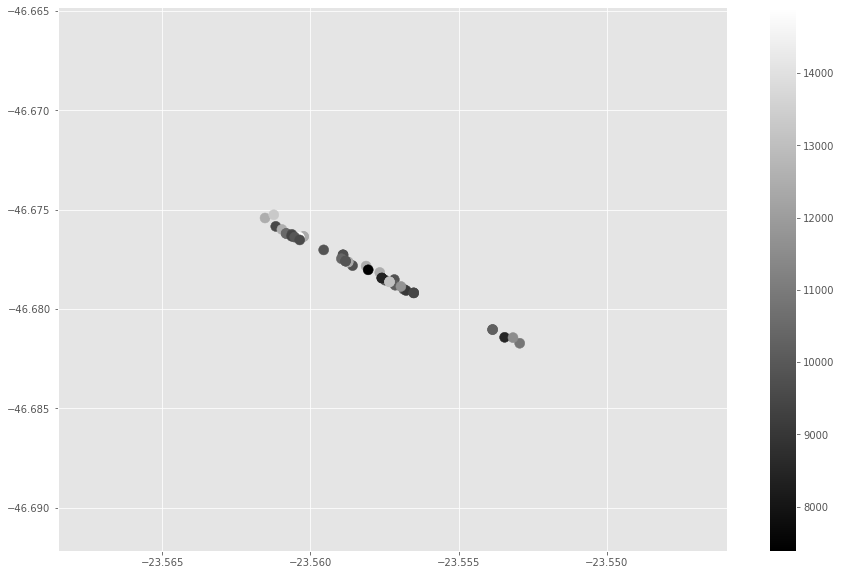

In [25]:
fig = plt.figure(figsize=(15,10))
_ = plt.scatter(cristiano_viana_st["latitude"].astype(np.float64), cristiano_viana_st["longitude"].astype(np.float64), c=cristiano_viana_st["estimate_sqm"], s=100)
plt.gray()
plt.colorbar()

## Considerations about geographic coordinates

The geographic coordinates are very important features in AVMs. The specific location can encode a lot of information, especially from intangible amenities such as crime rate, pleasant view and access to public transportation in the vicinity. Those are features that are hard to encode separately and, therefore, it's a very good thing it's encoded within the two geographic coordinates.

At the same time, the granularity of both latitude and longitude fields might pose a problem if we treat them as continuous numerical features. A latitude value hardly means much without a corresponding longitude value. Because of that, we can consider them to be linked and find ways to "group" them together.

Before doing that, there is also a consideration about precision. 8 decimal places correspond to an order of precision of `1 milimeter`, which is exaggerated considering that for residential real estate the common measure is `meter`, or 5 decimal degrees.

A good way to couple together those two features is the usage of space-filling curves through algorithms like Geohash or S2 Geometry. Those algorithms provide different precision type cells which can be leveraged to fit our needs.